In [0]:
from google.colab import drive
# drive.mount("/content/gdrive")

# Table of contents


1.   <a href='#1'>Problem statement</a>
2.   <a href='#1'>EDA</a>
3. <a href='#1'>Data Augmentation</a>
4. <a href='#1'>Bottleneck persistence</a>
5. <a href='#1'>Network Definition</a>
5. <a href='#1'>Model compilation</a>
6. <a href='#1'>Model fitting </a>
7. <a href='#1'>Model reporting</a>
8. <a href='#1'>Inference on test data</a>








## <a id='1'> Problem statement<a>

**Overview**

White blood cells (also known as WBC or leukocytes) help our body fight infections by attacking bacteria, viruses and other germs that invade the body. A count of leukocytes can help reveal several hidden and undiagnosed diseases. In a manual microscopic review of blood samples, pathologists minutely examine the count and morphology (i.e. size and shape) of white blood cells. White blood cells are of several types, and each type has a distinctive look. You can find a good primer on white blood cell types in the Wikipedia page.

Red blood cells (or RBC, or erythrocytes) are the most common type of blood cells, and they outnumber WBCs by about 600:1. So, in an image of a blood sample, you will see mostly RBCs, with a few WBCs thrown in here and there.

You are supposed come up with a method that will accurately demarcates the boundary of white blood cells in microscopic images of blood.



---


**About Data**

The training set consists of ***169 128X128*** patches showing WBCs, and the area has been demarcated in a mask file. The cell at the centre of these patches are WBCs, while those surrounding the WBC are RBCs. 

The files are named like ***train-0.jpg, train-1.jpg, ...*** . The corresponding mask files are named train-0-mask.jpg, train-1-mask.jpg, ... , respectively. 

There are also around 5 larger images (and corresponding masks) of blood, showing one or more WBCs in the image. The test set will consist of larger images of blood smears, from which we need to demarcate the WBC boundaries. 

---
**Objective** 

So, your code has to both locate the WBCs and demarcate their boundary.

---

**Evaluation **

We will compare the regions demarcated with your method on the test images with the regions we have demarcated. 

*Note* : Data has been attached with the question in the form of a zip file.


## <a id='2'>EDA</a>

In [0]:
from __future__ import print_function

import os
import shutil
import random
import numpy as np
import cv2
from glob import glob
import random 
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
train_data_path = "/content/gdrive/My Drive/colab/sigtuple/SigTuple_data/Train_Data"
test_data_path = "/content/gdrive/My Drive/colab/sigtuple/SigTuple_data/Test_Data"

train_files = glob(train_data_path+"/*.jpg")
test_files = glob(test_data_path+"/*.jpg")

In [0]:
train_files = sorted(train_files)

train_mask = list(filter(lambda x: "mask" in x ,train_files))
train_data = list(filter(lambda x: "mask" not in x ,train_files))

test_mask = list(filter(lambda x: "mask" in x ,test_files))
test_data = list(filter(lambda x: "mask" not in x ,test_files))

print("Total {} training images".format(len(train_data)))
print("Total {} testing images".format(len(test_data)))

print("Total {} training mask images".format(len(train_mask)))
print("Total {} testing mask images".format(len(test_mask)))

Total 169 training images
Total 61 testing images
Total 169 training mask images
Total 0 testing mask images


In [0]:
def read_image(image_url):
    original_image = cv2.imread(image_url)
    original_image =  original_image[:,:,::-1]
    return original_image

def segment_image(id):
#     mask_url,image_url
    original_image = read_image(train_data[id])
    masked_image = read_image(train_mask[id])
    segmented_img = cv2.bitwise_and(original_image, masked_image)
    print("original image shape {}".format(original_image.shape))
    print("mask image shape {}".format(masked_image.shape))
    return original_image,masked_image,segmented_img
 
def plot_img(img_array):
  plt.imshow(img_array)
  plt.axis('off')
  plt.grid(None)
  plt.show()

original image shape (128, 128, 3)
mask image shape (128, 128, 3)


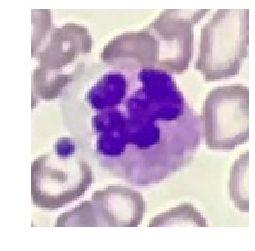

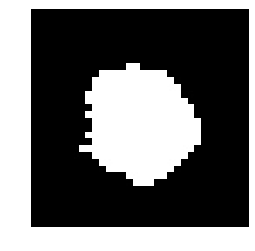

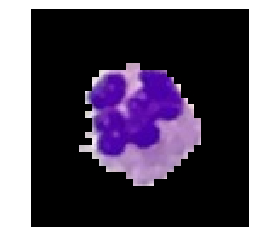

In [0]:
original_image,masked_image,segmented_img = segment_image(10)
plot_img(original_image)
plot_img(masked_image)
plot_img(segmented_img)

original image shape (912, 1178, 3)
mask image shape (912, 1178, 3)


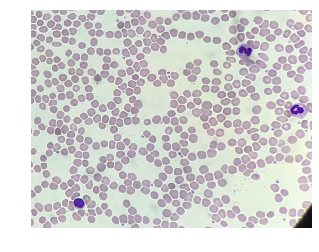

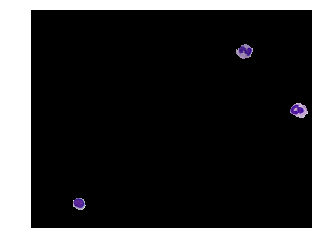

In [0]:
idx=3
original_image,masked_image,segmented_img = segment_image(idx)
plot_img(original_image)
plot_img(segmented_img)

## <a id='3'>Data Augmentation : Rotate images and mask</a>

In [0]:
   
def create_rotated_imgs(image_list,mask_list, ratio, max_angle):

    assert len(image_list) == len(mask_list),"image and mask num mismatch"
    
    total_images = len(image_list)
    indices = list(range(total_images))
    num_samples_to_pick = int(ratio * total_images)
    picked_indices = random.sample(indices,num_samples_to_pick)
    print("Picked {} images for transformation".format(len(picked_indices)))
    for i in picked_indices:
        image_name = Path(image_list[i]).stem
        print(image_name)
        if 'rot' in image_name:
            print("{} already exists.skipping ...".format(image_name))
            continue
            
        image_parent_dir = str(Path(train_files[i]).parent)
        
        # filenames for the rotated images
        rot_name = image_name+ '_rot.jpg'
        rot_mask_name = image_name+ '_rot-mask.jpg'
        rotated_image_path = os.path.join(image_parent_dir, rot_name)
        rotated_mask_path = os.path.join(image_parent_dir, rot_mask_name)
        
#         image_mask_name = image_name.split('.')[0] + '-mask.jpg'
        img = cv2.imread(image_list[i])
        img_mask = cv2.imread(mask_list[i])
        image_rows, image_cols,image_depth = img.shape
        
        # random rotation of the image and its mask
        angle = random.randint(-max_angle, max_angle)
        Rotation_matrix = cv2.getRotationMatrix2D((image_cols/2,image_rows/2),angle,1)
        rotated_im = cv2.warpAffine(img,Rotation_matrix,(image_cols, image_rows))
        rotated_im_mask = cv2.warpAffine(img_mask,Rotation_matrix,(image_cols, image_rows))
        
        # saving the rotated image and mask
        cv2.imwrite(rotated_image_path, rotated_im)
        cv2.imwrite(rotated_mask_path, rotated_im_mask)
        print("saved ",rotated_image_path)

In [0]:
random.seed(112)
# create_rotated_imgs(train_data,train_mask,1, 180)

## <a id='4'>Bottleneck persistence</a>

In [0]:

image_array_path = 'imgs_train.npy'
image_mask_array_path = 'imgs_mask_train.npy'

test_image_array_path = 'imgs_test.npy'
test_id_array_path = 'imgs_id_test.npy'
test_image_shape_path = 'imgs_size.npy'

model_dir = './'
train_mean_path = './train_mean.npy'
train_std_path = './train_std.npy'

In [0]:
image_rows = 128
image_cols = 128

In [0]:
def create_train_data():
    train_data_path = os.path.join(data_path, 'Train_Data')
    images = os.listdir(train_data_path)
    total = len(images) // 2

    imgs = np.ndarray((total, image_rows, image_cols, 3), dtype=np.uint8)
    imgs_mask = np.ndarray((total, 1, image_rows, image_cols), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        if 'mask' in image_name:
            continue
        image_mask_name = image_name.split('.')[0] + '-mask.jpg'
        
        img = cv2.imread(os.path.join(train_data_path, image_name))
        img = cv2.resize(img,(image_rows,image_cols))
        
        img_mask = cv2.imread(os.path.join(train_data_path, image_mask_name), cv2.IMREAD_GRAYSCALE)
        img_mask = cv2.resize(img_mask,(image_rows,image_cols))
        
        img = np.array([img])
        img_mask = np.array([img_mask])

        imgs[i] = img
        imgs_mask[i] = img_mask

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    print(imgs_mask.shape)
    np.save(image_array_path, imgs)
    np.save(image_mask_array_path, imgs_mask)
    print('Saving to .npy files done.')

def create_test_data():
    test_data_path = os.path.join(data_path, 'Test_Data')
    images = os.listdir(test_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols, 3), dtype=np.uint8)
    imgs_id = np.ndarray((total), dtype=np.object)
    imgs_size = np.ndarray((total), dtype=np.object)
    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    for image_name in images:
        img = cv2.imread(os.path.join(test_data_path, image_name))
        img_size = str(img.shape[0]) +","+str(img.shape[1])
        img = cv2.resize(img,(image_rows,image_cols))
        img = np.array([img])
        img_id = image_name.split('.')[0] + "-mask"
        
        imgs_id[i] = img_id
        imgs[i] = img
        imgs_size[i] = img_size
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save(test_image_array_path, imgs)
    np.save(test_id_array_path, imgs_id)
    np.save(test_image_shape_path,imgs_size)
    print('Saving to .npy files done.')


In [0]:

# create_train_data()
# create_test_data()


In [0]:
def load_train_data():
    imgs_train = np.load(image_array_path)
    imgs_mask_train = np.load(image_mask_array_path)
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load(test_image_array_path)
    imgs_id = np.load(test_id_array_path)
    imgs_size = np.load(test_image_shape_path)
    return imgs_test,imgs_id,imgs_size

## <a id='5'>Network Definition</a>

In [0]:
from keras import backend as K
from keras.layers import (Activation, Convolution2D, Dropout, Input, MaxPooling2D)
from keras.layers.normalization import BatchNormalization

from keras.models import Sequential
from keras.optimizers import SGD

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam

In [0]:

def get_model(X_train):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same',input_shape=(image_rows,image_cols,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    

    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Convolution2D(1, 1, 1, border_mode='same'))
    model.add(Activation('sigmoid'))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def preprocess(imgs_train,imgs_mask_train):
    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization
    imgs_train -= mean
    imgs_train /= std
    return imgs_train,mean,std


## <a id='6'>Model Compilation</a>

In [0]:
def modelCallbacks():
    early_stopping = EarlyStopping(patience=10, verbose=1)
    model_path=model_dir+"/"+"model.hdf5"
    model_checkpoint = ModelCheckpoint(model_path, monitor='acc', verbose=1, save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    return model_path, [early_stopping, model_checkpoint, reduce_lr]

def save_model_auxiliaries(mean,std):
  np.save(train_mean_path,mean)
  np.save(train_std_path,std)
  return train_mean_path,train_std_path
  
def train_and_save(epochs = 150,batch_size = 64):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()
    imgs_mask_train = imgs_mask_train.reshape(imgs_mask_train.shape[0], 
                                              image_rows, image_cols, 1)
    
    imgs_train,mean,std = preprocess(imgs_train,imgs_mask_train)
    
    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]
    
    train_mean_path,train_std_path = save_model_auxiliaries(mean,std)
    
    print("Train data shape",imgs_train.shape)
    print("Mask as label shape",imgs_mask_train.shape)
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_model(imgs_train)
    model_path,callbacks = modelCallbacks()
    
    history = model.fit(imgs_train, imgs_mask_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks)
    return model_path,history,train_mean_path,train_std_path

## <a id='7'>Model fitting</a>

In [0]:

model_path,history,train_mean_path,train_std_path = train_and_save()

------------------------------
Loading and preprocessing train data...
------------------------------
Train data shape (253, 128, 128, 3)
Mask as label shape (253, 128, 128, 1)
------------------------------
Creating and compiling model...
------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(128, 128,..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call

Epoch 1/150
253/253 [==============================] - 4s 16ms/step - loss: 0.5108 - acc: 0.7293

Epoch 00001: acc improved from -inf to 0.72934, saving model to .//model.hdf5


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/150
253/253 [==============================] - 2s 7ms/step - loss: 0.2048 - acc: 0.9136

Epoch 00002: acc improved from 0.72934 to 0.91364, saving model to .//model.hdf5
Epoch 3/150
253/253 [==============================] - 2s 7ms/step - loss: 0.1645 - acc: 0.9256

Epoch 00003: acc improved from 0.91364 to 0.92564, saving model to .//model.hdf5
Epoch 4/150
253/253 [==============================] - 2s 7ms/step - loss: 0.1507 - acc: 0.9291

Epoch 00004: acc improved from 0.92564 to 0.92911, saving model to .//model.hdf5
Epoch 5/150
253/253 [==============================] - 2s 7ms/step - loss: 0.1409 - acc: 0.9298

Epoch 00005: acc improved from 0.92911 to 0.92980, saving model to .//model.hdf5
Epoch 6/150
253/253 [==============================] - 2s 7ms/step - loss: 0.1361 - acc: 0.9311

Epoch 00006: acc improved from 0.92980 to 0.93109, saving model to .//model.hdf5
Epoch 7/150
253/253 [==============================] - 2s 7ms/step - loss: 0.1321 - acc: 0.9320

Epoch 00007: 

## <a id='8'>Model report</a>

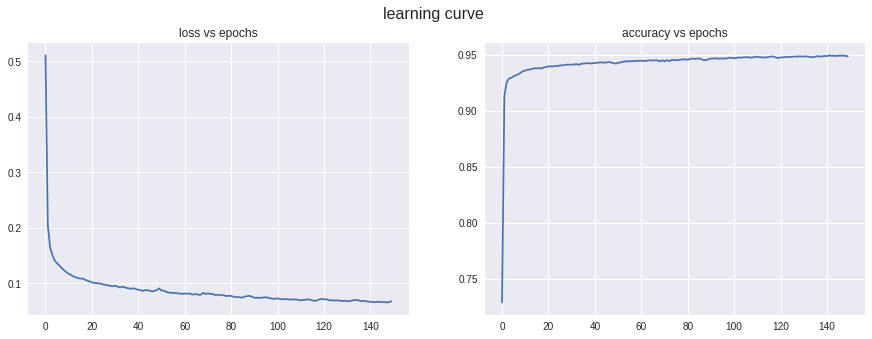

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
# fig.set({"title":'learning curve'})
fig.suptitle("learning curve", fontsize=16)
_ = ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
_ = ax_loss.set_title('loss vs epochs')
_ = ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
_ = ax_acc.set_title('accuracy vs epochs')

In [0]:
data_path = '/content/gdrive/My Drive/colab/sigtuple/SigTuple_data'
output_folder = data_path+"/output4/"

## <a id='1'>InferencePhase</a>

In [0]:
def load_model_and_auxiliaries(model_path,train_mean_path,train_std_path):
  from keras.models import load_model
  model = load_model(model_path)
  mean = np.load(train_mean_path)
  std = np.load(train_std_path)
  return model,mean,std

model,mean,std = load_model_and_auxiliaries(model_path,train_mean_path,train_std_path)

In [0]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test, imgs_id, imgs_size = load_test_data()

# mean = np.mean(imgs_test)  # mean for data centering
# std = np.std(imgs_test)  # std for data normalization
imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
print('test image shape ',imgs_mask_test.shape)
imgs_mask_test = model.predict(imgs_test, verbose=1)
imgs_mask_test *= 255

if os.path.exists(output_folder):
      shutil.rmtree(output_folder)
      print("folder removed")
os.makedirs(output_folder)

i=0

for img,name,size in zip(imgs_mask_test,imgs_id,imgs_size):    
    img=cv2.resize(img, (int(size.split(',')[1]) , int(size.split(',')[0])))
    ret,img = cv2.threshold(img,200,255,cv2.THRESH_BINARY) ## remove any grays
    mask_path = str(Path(output_folder) / (str(name) +".jpg"))
    
    cv2.imwrite(mask_path, img )
    i+=1

print("Predictions saved as mask for {} images!!!".format(i))


------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
test image shape  (61, 128, 128, 1)
61/61 [==============================] - 1s 18ms/step
folder removed
Predictions saved as mask for 61 images!!!


## Problem 2 :

Given an array which is sorted but can be rotated around an index in the array. For example , if the array is [5,6,1,2,3] the index of rotation is 2. If there is any index of rotaion find it. If there is no index of rotation print -1,i.e. the array is already sorted.

In [0]:
def findRorationIndex(arr): 
    min_element = arr[0] 
    n = len(arr)
    min_element_index = -1
    for i in range(0, n): 
        if (min_element > arr[i]): 
            min_element = arr[i] 
            min_element_index = i    
    print(min_element_index)
    return min_element_index; 

In [0]:
# Test cases
arr1 = [3,4,5,0,1,2]  ## the index of rotation should be 3
arr2 = [88,99,22,34,57]  ## the index of rotation should be 2
arr3 = [1,2,3,4] ## is already sorted , should return -1

assert findRorationIndex(arr1) == 3,"Test failed "
assert findRorationIndex(arr2) == 2,"Test failed"
assert findRorationIndex(arr3) == -1,"Test failed"


3
2
-1
